In [884]:
import numpy as np
import matplotlib.pyplot as plt

In [885]:
z_max = 2.5
learning_rate = 0.01

In [886]:
def Gaussian(x, μ, σ):
    return 1/(σ*np.sqrt(2*np.pi))*np.exp(-(x-μ)**2/(2*σ**2))

In [887]:
def KL_divergence(μ1, σ1, μ2, σ2):
    return np.log(σ2/σ1) + (σ1**2 + (μ1 - μ2)**2)/(2*σ2**2) - 1/2

In [888]:
w1 = 1
v1 = 1
w2 = 1
v2 = 1
nl = [0,0]
nr = [0,0]
w3 = 1
v3 = 1
w4 = 1
v4 = 1

In [889]:
def node_input(μ_input, σ_input):
    return [μ_input, σ_input] # none
    # return [1 / (1 + np.exp(-μ_input)), σ_input] # Sigmoid
    # return [np.tanh(μ0), σ0] # tanh
    # return [(μ_input > 0) * 1, σ_input] # relu

In [890]:
def node_left(μ0, σ0):
    global nl
    nl = [μ0*w1, v1**2*μ0**2 + σ0**2]
    return nl
    # nl = [1 / (1 + np.exp(-μ0*w1)), v1**2*μ0**2 + σ0**2]
    # return [(μ0*w1 > 0) * 1, v1**2*μ0**2 + σ0**2]

In [891]:
def node_right(μ0, σ0):
    global nr
    nr = [μ0*w2, v2**2*μ0**2 + σ0**2]
    return nr # Sigmoid
    # return [(μ0*w2 > 0) * 1, v2**2*μ0**2 + σ0**2]

In [892]:
def node_output(μ1, σ1, μ2, σ2):
    return [μ1*w3 + μ2*w4, v3**2*μ1**2 + σ1**2 + v4**2*μ2**2 + σ2**2] # Sigmoid
    # return [(μ1*w3 + μ2*w4 > 0) * 1, v3**2*μ1**2 + σ1**2 + v4**2*μ2**2 + σ2**2]

In [893]:
def predict(μ_input, σ_input):
    μ0 = node_input(μ_input, σ_input)[0]
    σ0 = node_input(μ_input, σ_input)[1]
    μ1 = node_left(μ0, σ0)[0]
    σ1 = node_left(μ0, σ0)[1]
    μ2 = node_right(μ0, σ0)[0]
    σ2 = node_right(μ0, σ0)[1]
    μ_output = node_output(μ1, σ1, μ2, σ2)[0]
    σ_output = node_output(μ1, σ1, μ2, σ2)[1]
    return [μ_output, σ_output]

In [894]:
ensemble_predictions = np.loadtxt("Desktop/PhotoZ/"+"06_2022"+"/29_15h02m47s1_1_1_1_1_1_1_1__ensemble.csv",skiprows=0,delimiter = ',')

In [895]:
μ_input_array = ensemble_predictions[:,2]
σ_input_array = ensemble_predictions[:,3]
y_array = ensemble_predictions[:,1]
μ_output_array = [0] * len(y_array)
σ_output_array = [1] * len(y_array)

In [896]:
def loss():
    total_prob = 0
    for i in range(0, len(y_array)):
        prob_y = Gaussian(y_array[i], μ_output_array[i], σ_output_array[i])
        total_prob += prob_y
    return KL_divergence(w1, v1, 1, 0)+KL_divergence(w2, v2, 1, 0)+KL_divergence(w3, v3, 1, 0)+KL_divergence(w4, v4, 1, 0)-total_prob

In [897]:
def error_no(y, μ_output, σ_output):
    return (1-Gaussian(y, μ_output, σ_output))*(μ_output - y)#*μ_output*(1 - μ_output)# + KL_divergence(0, 1, w1, v1) + KL_divergence(0, 1, w2, v1) + KL_divergence(0, 1, w3, v3) + KL_divergence(0, 1, w4, v4) # only for sigmoid

In [898]:
def error_w3(error_no):
    return w3*error_no

In [899]:
def error_w4(error_no):
    return w4*error_no

In [900]:
def error_w1(error_w3):
    return w1*error_w3

In [901]:
def error_w2(error_w4):
    return w2*error_w4

In [902]:
def train(y, μ_input, σ_input):
    predicted = predict(μ_input, σ_input)
    err_no = error_no(y, predicted[0], predicted[1])
    global w3
    w3 = w3 - error_w3(err_no) * learning_rate * nl[0]
    global w4
    w4 = w4 - error_w4(err_no) * learning_rate * nr[0]
    global w1
    w1 = w1 - error_w1(error_w3(err_no)) * learning_rate * μ_input
    global w2
    w2 = w2 - error_w2(error_w4(err_no)) * learning_rate * μ_input
    global v3
    v3 = np.abs(v3 - error_w3(err_no) * learning_rate * nl[1])
    global v4
    v4 = np.abs(v4 - error_w4(err_no) * learning_rate * nr[1])
    global v1
    v1 = np.abs(v1 - error_w1(error_w3(err_no)) * learning_rate * σ_input)
    global v2
    v2 = np.abs(v2 - error_w2(error_w4(err_no)) * learning_rate * σ_input)
    return predicted

In [903]:
for i in range(0, 25):
    for j in range(0, len(y_array)):
        y_predicted = train(y_array[j], μ_input_array[j], σ_input_array[j])
        μ_output_array[j] = y_predicted[0]
        σ_output_array[j] = y_predicted[1]
    # print(loss())

(0.0, 2.5)

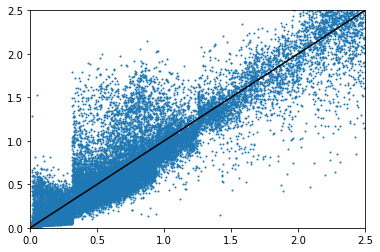

In [904]:
fig, ax = plt.subplots()
scatter_plot = ax.scatter(y_array, μ_output_array, s = 1, edgecolor = None)
plt.plot([0, z_max], [0, z_max],color = 'black')
plt.xlim([0, z_max])
plt.ylim([0, z_max])

In [905]:
print(w1)
print(w2)
print(w3)
print(w4)

10.622580290850676
10.622580290850676
0.05272001123018487
0.05272001123018487


In [906]:
# END